In [1]:
# 라이브러리 임포트
# 세션 변경으로 GPU 설정

import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GRU, Dropout, Dense, Flatten, MaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
# 1. 데이터 로드 함수 (CNN과 동일)

# 파일 로드 함수
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# 그룹 로드
def load_group(filenames, prefix=''):
    loaded = [load_file(prefix + name) for name in filenames]
    return np.dstack(loaded)

# train/test 그룹 데이터셋 로드
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = [
        # total acceleration
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        # body acceleration
        'body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt',
        # body gyroscope
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

# 전체 데이터 로드
def load_dataset(prefix=''):
    dataset_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로그래밍/10주/UCI HAR Dataset/'
    trainX, trainy = load_dataset_group('train', dataset_path)
    testX, testy = load_dataset_group('test', dataset_path)

    # 0부터 시작하도록 조정
    trainy, testy = trainy - 1, testy - 1

    # One-hot encoding
    trainy_one_hot, testy_one_hot = to_categorical(trainy), to_categorical(testy)

    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

# 2. 데이터 불러오기 및 분할

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy,
    test_size=0.2,
    random_state=100
)

print(X_train.shape, X_val.shape, y_train_one_hot.shape, y_val_one_hot.shape)

/tmp/ipython-input-656891497.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-656891497.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-656891497.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-656891497.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp

(7352, 128, 9) (7352, 1) (2947, 128, 9) (2947, 1)
(5881, 128, 9) (1471, 128, 9) (5881, 6) (1471, 6)


In [3]:
# 3. CNN + GRU 모델 정의

cnn_gru_model = Sequential([
    # CNN Feature Extractor
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # GRU Layer
    GRU(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.2),

    # Fully Connected Classifier
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')
])

cnn_gru_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

cnn_gru_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 126, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 61, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,982 (527.27 KB)

 Trainable params: 134,598 (525.77 KB)

 Non-trainable params: 384 (1.50 KB)

In [4]:
# 4. 모델 학습

history = cnn_gru_model.fit(
    X_train, y_train_one_hot,
    validation_data=(X_val, y_val_one_hot),
    epochs=30,
    batch_size=64,
    verbose=1
)

Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.5937 - loss: 0.9479 - val_accuracy: 0.2937 - val_loss: 2.2626
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 164ms/step - accuracy: 0.8793 - loss: 0.3235 - val_accuracy: 0.3236 - val_loss: 2.9455
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 0.9290 - loss: 0.1821 - val_accuracy: 0.5568 - val_loss: 1.8876
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.9369 - loss: 0.1532 - val_accuracy: 0.8511 - val_loss: 0.5635
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 171ms/step - accuracy: 0.9500 - loss: 0.1355 - val_accuracy: 0.8939 - val_loss: 0.3609
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 0.9529 - loss: 0.1264 - val_accuracy: 0.9422 - val_loss: 0.1358
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - accuracy: 0.9503 - loss: 0.1264 - val_accuracy: 0.9449 - val_loss: 0.1254
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - accuracy: 0.9516 - loss: 0.1164 - val_accur

In [5]:
# 5. 평가

loss, acc = cnn_gru_model.evaluate(testX, testy_one_hot, verbose=0)
print(f'Test Accuracy: {acc:.4f}')

Test Accuracy: 0.9216


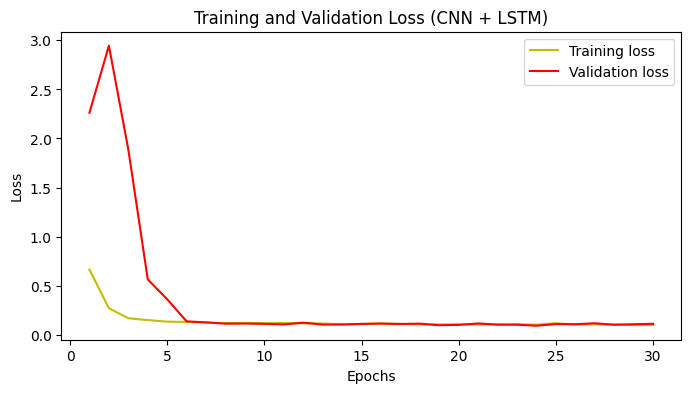

In [6]:
# 6. 학습 결과 시각화

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# 손실 그래프

plt.figure(figsize=(8, 4))
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss (CNN + GRU)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

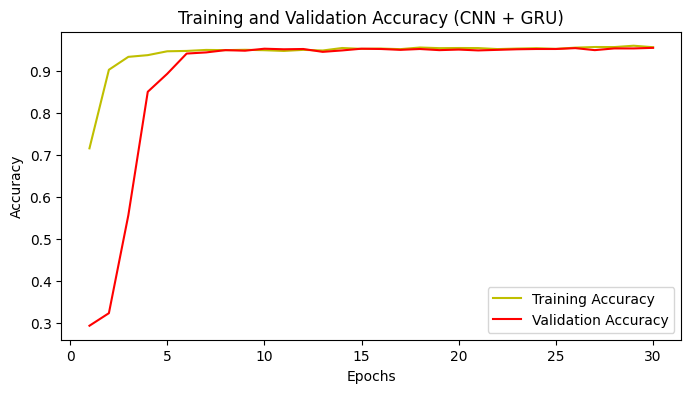

In [7]:
# 정확도 그래프

plt.figure(figsize=(8, 4))
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy (CNN + GRU)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
✅ Test Accuracy: 0.9216152019002375

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96       496
           1       0.99      0.98      0.99       471
           2       0.94      0.98      0.96       420
           3       0.84      0.77      0.80       491
           4       0.81      0.86      0.83       532
           5       0.99      1.00      0.99       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



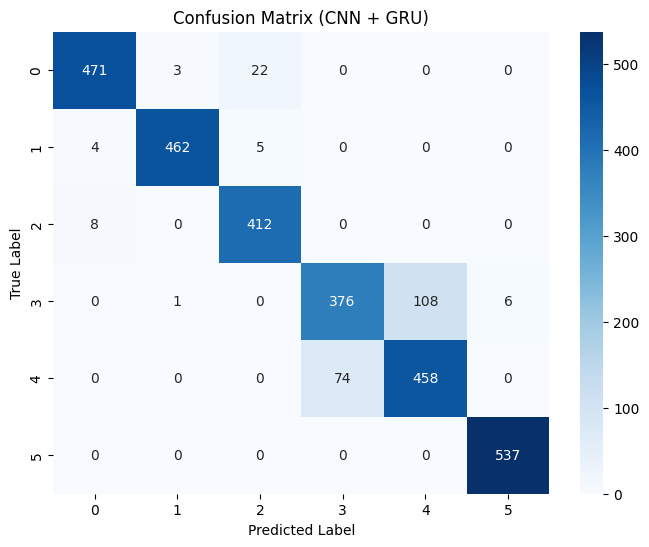

In [8]:
# 7. 예측 및 혼동행렬

pred = cnn_gru_model.predict(testX)
pred = np.argmax(pred, axis=-1)
true = np.argmax(testy_one_hot, axis=-1)

print("✅ Test Accuracy:", accuracy_score(true, pred))
print("\n📊 Classification Report:\n", classification_report(true, pred))

cm = confusion_matrix(true, pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (CNN + GRU)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()